In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os , shutil
import cv2
import matplotlib.image  as mpimg
import seaborn as sns
plt.style.use('ggplot')

In [9]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count)+".jpg"
    os.rename(source , destination)
    count+=1

In [16]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" + str(count)+".jpg"
    os.rename(source , destination)
    count+=1

In [17]:
# EDA

In [18]:
# yes
list_Yes = os.listdir("brain_tumor_dataset/yes/")
length_yes = len(list_Yes);
print(length_yes)

# no
list_No = os.listdir("brain_tumor_dataset/no/")
length_no = len(list_No);
print(length_no)

155
98


In [19]:
# plot

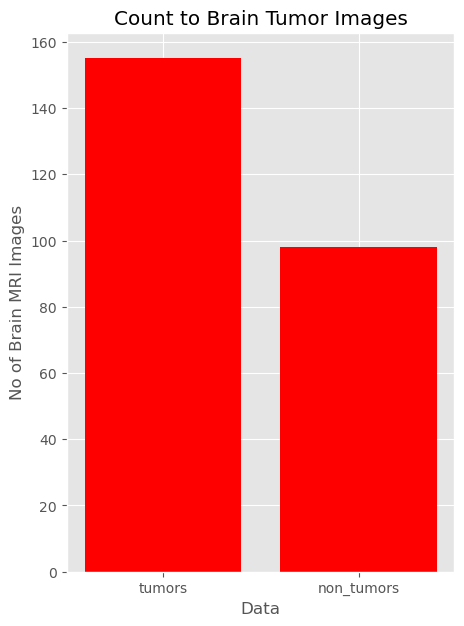

In [24]:
data = {'tumors' : length_yes , 'non_tumors' : length_no}

x = data.keys()
y = data.values()

fig = plt.figure(figsize=(5,7))
plt.bar(x , y  , color = "red")

plt.xlabel("Data")
plt.ylabel("No of Brain MRI Images")

plt.title("Count to Brain Tumor Images")
plt.show()

In [25]:
# Data Argumentation
# yes = 155 , no = 98
# its not balanced

# so we can just generate some more images generator

In [28]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten , Dense ,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD , Adam
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau

In [29]:
def argumented_data(file_dir , n_genetated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                       width_shift_range=0.1,
                       shear_range=0.1,
                       brightness_range=(0.3,1.0),
                       horizontal_flip= True,
                       vertical_flip=True,
                       fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir+ '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x = image , batch_size = 1 , save_to_dir = save_to_dir , save_prefix = save_prefix , save_format = "jpg"):
            i+=1
            if i>n_genetated_samples:
                break